In [1]:
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import dicom as pdicom
import os, sys
import subprocess as sp

In [3]:
import SimpleITK as sitk
import skimage.io as io

In [4]:
homeDir = "/mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/"
requestedPath = os.path.join(homeDir, 'brats_2013_pat0010_1')
mydatadir = os.path.realpath(requestedPath)
if not os.path.exists(mydatadir):
    print("The path %s does not exist" %(mydatadir))

In [5]:
MyFileURLs = {"T1": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T1.54567/VSD.Brain.XX.O.MR_T1.54567.mha'), 
              "T2": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T2.54569/VSD.Brain.XX.O.MR_T2.54569.mha'), 
              "FLAIR":os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha'), 
              "T1c": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha')}

In [6]:
img_T1 = sitk.ReadImage(MyFileURLs["T1"])
img_T2 = sitk.ReadImage(MyFileURLs["T2"])
img_FLAIR = sitk.ReadImage(MyFileURLs["FLAIR"])
img_T1c = sitk.ReadImage(MyFileURLs["T1c"])

## Image Smoothing/Denoising

In [7]:
img_T1_Smooth = sitk.CurvatureFlow(image1=img_T1, timeStep=0.125, numberOfIterations=5)
img_T2_Smooth = sitk.CurvatureFlow(image1=img_T2, timeStep=0.125,  numberOfIterations=5)
img_T1c_Smooth = sitk.CurvatureFlow(image1=img_T1c, timeStep=0.125, numberOfIterations=5)
img_FLAIR_Smooth = sitk.CurvatureFlow(image1=img_FLAIR, timeStep=0.125, numberOfIterations=5)

## Intensity Rescale

## Seed

In [8]:
# Slice index to visualize with 'sitk_show'
idxSlice = 77

# int label to assign to the segmented gray matter
labelGrayMatter = 1

lstSeeds = [(165, 178, idxSlice), (98, 165, idxSlice), (205, 125, idxSlice), (173, 205, idxSlice)]

In [9]:
# To visualize the labels image in RGB with needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1_Smooth), sitk.sitkUInt8)
img_T2_255 = sitk.Cast(sitk.RescaleIntensity(img_T2_Smooth), sitk.sitkUInt8)
img_FLAIR_255 = sitk.Cast(sitk.RescaleIntensity(img_FLAIR_Smooth), sitk.sitkUInt8)
img_T1c_255 = sitk.Cast(sitk.RescaleIntensity(img_T1c_Smooth), sitk.sitkUInt8)

In [10]:
imgGrayMatterT1 = sitk.ConfidenceConnected(image1=img_T1_Smooth, seedList=lstSeeds,
                                                numberOfIterations=3,multiplier=1, replaceValue=labelGrayMatter)
imgT1SmoothInt = sitk.Cast(sitk.RescaleIntensity(img_T1_Smooth), imgGrayMatterT1.GetPixelID())
imgGrayMatterT2 = sitk.ConfidenceConnected(image1=img_T2_Smooth, seedList=lstSeeds,
                                                numberOfIterations=3,multiplier=1, replaceValue=labelGrayMatter)
imgT2SmoothInt = sitk.Cast(sitk.RescaleIntensity(img_T2_Smooth), imgGrayMatterT2.GetPixelID())

## Intensity Non-uniformity Correction

## Image Registration using ANTs

In [11]:
from __future__ import print_function, unicode_literals
from builtins import open
from future import standard_library
standard_library.install_aliases()
import urllib.request
import urllib.error
import urllib.parse
from nipype.interfaces.ants import Registration

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
def applying_N3(inputList):
    output_dir = "data/N3_output/"
    command = "data/itkN3 %s %s" %(inputList, output_dir)
    sp.call(cmd)

In [13]:
reg = Registration()
reg.inputs.fixed_image = MyFileURLs["T1c"]
reg.inputs.moving_image = MyFileURLs["FLAIR"]
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'INTERNAL_WARPED.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 +
                                   [[100, 50, 30]])
reg.inputs.dimension = 3
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.01]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True


In [14]:
sp.run(reg.cmdline, shell=True, stdout=sp.PIPE)

CompletedProcess(args='antsRegistration --collapse-output-transforms 0 --dimensionality 3 --initial-moving-transform [ /mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha, /mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ output_, INTERNAL_WARPED.nii.gz ] --transform Translation[ 0.1 ] --metric Mattes[ /mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha, /mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha, 1, 32, Regular, 0.3 ] --convergence [ 10000x111110x11110, 1e-08, 20 ] --smoothing-sigmas 4.0x2.0x1.0vox --shrink-factors 6x4x2 --use-estimate-learning-rate-once 

In [23]:
reg.run()

OSError: No command "antsRegistration" found on host sara. Please check that the corresponding package is installed.

In [24]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive
from ipywidgets import widgets

def myshow(img, title=[], margin=0.05, dpi=80 ):
    nda = sitk.GetArrayViewFromImage(img)

    spacing = img.GetSpacing()
    slicer = False

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            slicer = True

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")

        # take a z-slice
        slicer = True
    

    if (slicer):
        ysize = nda.shape[1]
        xsize = nda.shape[2]
    else:
        ysize = nda.shape[0]
        xsize = nda.shape[1]


    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    def callback(z=None):        

        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)

        fig = plt.figure(figsize=figsize, dpi=dpi)

        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

        plt.set_cmap("gray")

        if z is None:
            ax.imshow(nda,extent=extent,interpolation=None)
        else:
            ax.imshow(nda[z,...],extent=extent,interpolation=None)
            if title:
                plt.title(title[z])
            
        plt.show()

    if slicer:
        if title:
            interact(callback, z=(0,nda.shape[0]-1))
        else:
            interact(callback, z=(0,nda.shape[0]-1))
    else:
        callback()

def myshow3d(img, xslices=[], yslices=[], zslices=[], title=[], margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
    


    myshow(img, title, margin, dpi)


In [25]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import numpy as np
from glob import glob
import skimage.io as io

def read_image_into_ndArray(imagefile, PlugIn):
    imageArray = io.imread(imagefile, plugin=PlugIn)
    print("The dimension of the image is ", imageArray.shape)
    return imageArray

def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(sitk.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(sitk.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    sitk_show(sitk.Compose(lstImgToCompose))

def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = sitk.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()
    
def figure_images(imageList, z):    
    i = 1
    for a_file in imageList:
        sliced = sitk.GetArrayViewFromImage(a_file[1])[z,:,:]        
        #plt.subplot(round(len(imageList)/3)+1,3, i)
        plt.figure()
        plt.title(a_file[0])
        plt.imshow(sliced, cmap=plt.cm.Greys_r)
        plt.axis('off')
        i = i+1

## Visualization

In [26]:
from ipywidgets import interact, FloatSlider

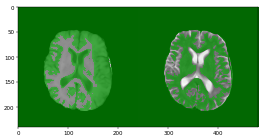

In [27]:
sitk_tile_vec([sitk.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], imgGrayMatterT1[:,:,idxSlice]),
               sitk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], imgGrayMatterT2[:,:,idxSlice])])

In [28]:
myshow3d(imgComp)
myshow3d(imgGrayMatterComp)

NameError: name 'imgComp' is not defined

In [29]:
sitk_show(sitk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], imgGrayMatterComp[:,:,idxSlice]))

NameError: name 'imgGrayMatterComp' is not defined

## Save 3D image Files

In [30]:
sitk.WriteImage(imgGrayMatterComp, "./GrayMatter.mha")

NameError: name 'imgGrayMatterComp' is not defined

In [31]:
def get_image_info(imgObject):
    imgDict = {}
    imgDict["Dimension"] = imgObject.GetDimension()
    imgDict["Size"] = imgObject.GetSize()
    imgDict["Num_Pixels"] = imgObject.GetNumberOfPixels()
    return imgDict

In [32]:
haha = get_image_info(imgComp)
print(haha)

NameError: name 'imgComp' is not defined